## Bài toán
Dữ liệu gồm n văn bản phân vào 10 chủ đề khác nhau. Cần xây dựng và đánh giá các mô hình dự đoán nhãn của các văn bản trên.

## Đánh giá và tối ưu hoá mô hình 

- Lựa chọn các giá trị của các tham số bằng các thử nghiệm. 
- Với mỗi bộ tham số: 
    - Sử dụng phương pháp cross-validate chia dữ liệu và training, để đánh giá mô hình một cách tổng quát. 
- Sử dụng độ đo Accuracy để làm độ đo đánh giá chất lượng mô hình. 
- Với mỗi mô hình, tìm ra bộ tham số tốt nhất, và tiếp tục thử các mô hình khác. 
- So sánh các mô hình

## Mục lục
- Load dữ liệu từ thư mục
- Chuyển dữ liệu dạng text về ma trận (n x m) bằng TF. Chuyển nhãn các văn bản về dạng số.
- Lựa chọn tham số các mô hình SVM (kernel, C), Random Forest (criteria, N)
- So sánh 2 mô hình tốt nhất

In [69]:
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve
from tqdm import tqdm

from sklearn.datasets import make_blobs, load_files
from pyvi import ViTokenizer


from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

%matplotlib inline

## 1. Load dữ liệu từ thư mục

Cấu trúc thư mục như sau 

- data/news_vnexpress/

    - Kinh tế: 
        - bài báo 1.txt 
        - bài báo 2.txt 
    - Pháp luật
        - bài báo 3.txt 
        - bài báo 4.txt 

In [35]:
INPUT = 'data/news_vnexpress'
os.makedirs("images",exist_ok=True)  # thư mục lưu các các hình ảnh trong quá trình huấn luyện và đánh gía

In [27]:
# statistics
print('Các nhãn và số văn bản tương ứng trong dữ liệu')
print('----------------------------------------------')
n = 0
for label in os.listdir(INPUT):
    print(f'{label}: {len(os.listdir(os.path.join(INPUT, label)))}')
    n += len(os.listdir(os.path.join(INPUT, label)))

print('-------------------------')
print(f"Tổng số văn bản: {n}")

Các nhãn và số văn bản tương ứng trong dữ liệu
----------------------------------------------
doi-song: 120
du-lich: 54
giai-tri: 201
giao-duc: 105
khoa-hoc: 144
kinh-doanh: 262
phap-luat: 59
suc-khoe: 162
the-thao: 173
thoi-su: 59
-------------------------
Tổng số văn bản: 1339


In [36]:
# load data
data_train = load_files(container_path=INPUT, encoding="utf-8")

print('mapping:')
for i in range(len(data_train.target_names)):
    print(f'{data_train.target_names[i]} - {i}')

print('--------------------------')
print(data_train.filenames[0:1])
# print(data_train.data[0:1])
print(data_train.target[0:1])
print(data_train.data[0:1])

print("\nTổng số  văn bản: {}" .format( len(data_train.filenames)))

mapping:
doi-song - 0
du-lich - 1
giai-tri - 2
giao-duc - 3
khoa-hoc - 4
kinh-doanh - 5
phap-luat - 6
suc-khoe - 7
the-thao - 8
thoi-su - 9
--------------------------
['data/news_vnexpress\\khoa-hoc\\00133.txt']
[4]
['Mời độc giả đặt câu hỏi tại đây\n']

Tổng số  văn bản: 1339


## 2. Chuyển dữ liệu dạng text về ma trận (n x m) bằng TF. Chuyển nhãn các văn bản về dạng số

In [37]:
# load dữ liệu các stopwords 
with open("data/vietnamese-stopwords.txt", encoding="utf-8") as f:
    stopwords = f.readlines()
stopwords = [x.strip().replace(" ", "_") for x in stopwords] 
print(f"Số lượng stopwords: {len(stopwords)}")
print(stopwords[:10])

# Chuyển hoá dữ liệu text về dạng vector TF 
#     - loại bỏ từ dừng
#     - sinh từ điển
module_count_vector = CountVectorizer(stop_words=stopwords)
model_rf_preprocess = Pipeline([('vect', module_count_vector),
                    ('tf', TfidfTransformer()),
                    ])
# Hàm thực hiện chuyển đổi dữ liệu text thành dữ liệu số dạng ma trận 
# Input: Dữ liệu 2 chiều dạng numpy.array, mảng nhãn id dạng numpy.array 
data_preprocessed = model_rf_preprocess.fit_transform(data_train.data, data_train.target)

print(f"\nSố lượng từ trong từ điển: {len(module_count_vector.vocabulary_)}")
print(f"Kích thước dữ liệu sau khi xử lý: {data_preprocessed.shape}")
print(f"Kích thước nhãn tương ứng: {data_train.target.shape}")

Số lượng stopwords: 2063
['a_lô', 'a_ha', 'ai', 'ai_ai', 'ai_nấy', 'ai_đó', 'alô', 'amen', 'anh', 'anh_ấy']

Số lượng từ trong từ điển: 12796
Kích thước dữ liệu sau khi xử lý: (1339, 12796)
Kích thước nhãn tương ứng: (1339,)


## 3. Lựa chọn tham số cho các mô hình

In [55]:
# Chia dữ liệu thành 2 phần: train và test
p = 0.2
pivot = int(data_preprocessed.shape[0] * (1-0.2))
X_train, X_test = data_preprocessed[0:pivot], data_preprocessed[pivot:]
Y_train, Y_test = data_train.target[0:pivot], data_train.target[pivot:]

Lựa chọn tham số các mô hình SVM (kernel, C), Random Forest (criteria, N), K - Nearest Neighbor

- Viết hàm thực hiện huấn luyện mô hình và đánh giá
- Sử dụng các thư viện hỗ trợ để vẽ đồ thị toàn bộ quá trình huấn luyện

In [58]:
def cross_validation(estimator):
    _, train_scores, test_scores = learning_curve(estimator, X_train, Y_train, cv=10, n_jobs=-1, train_sizes=[1.0, ], scoring="accuracy")
    test_scores = test_scores[0]
    mean, std = test_scores.mean(), test_scores.std()
    return mean, std

def plot(title, xlabel, X, Y, error, ylabel = "Accuracy"):
    plt.xlabel(xlabel)
    plt.title(title)
    plt.grid()
    plt.ylabel(ylabel)
    
    plt.errorbar(X, Y, error, linestyle='None', marker='o')

### Kernel trong mô hình SVM

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:05<00:00, 16.35s/it]


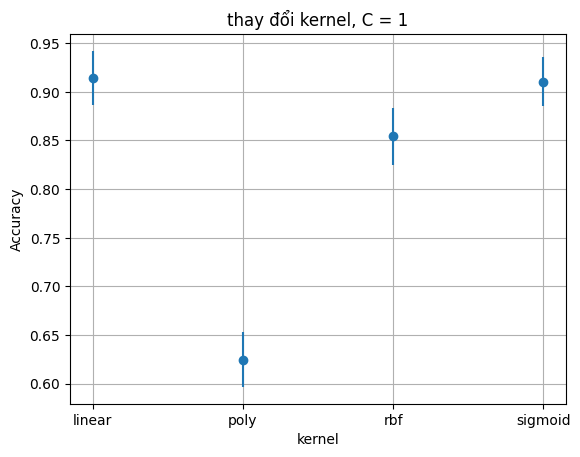

In [59]:
title = "thay đổi kernel, C = 1"
xlabel = "kernel"
X = []
Y = []
error = []

for kernel in tqdm(['linear', 'poly', 'rbf', 'sigmoid']):
    # Với mỗi kernel được chọn, 
    # thực hiện xây dựng mô hình, huấn luyện và đánh giá theo cross-validation
    text_clf = svm.SVC(kernel=kernel, C=1.0)
    mean, std = cross_validation(text_clf)
    X.append(kernel)
    Y.append(mean)
    error.append(std)

# lưu kết quả ra file ảnh 
plot(title, xlabel, X, Y, error)
plt.savefig('images/svm_change_kernel.png', bbox_inches='tight')
plt.show()


### C trong mô hình SVM

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:19<00:00, 15.82s/it]


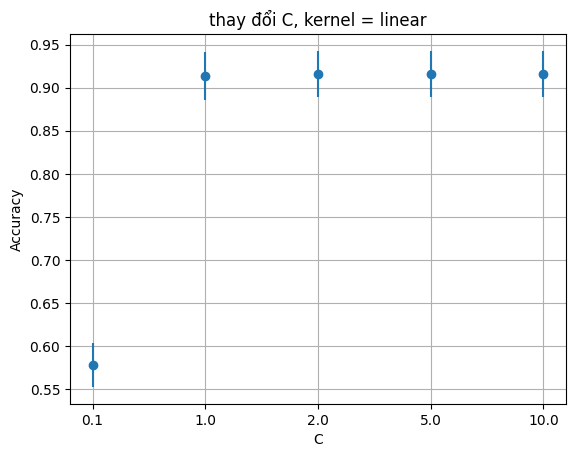

In [60]:
title = "thay đổi C, kernel = linear"
xlabel = "C"
X = []
Y = []
error = []

for C in tqdm([.1, 1.0, 2.0, 5.0, 10.0]):
    # Với từng giá trị C nhận được, 
    # thực hiện xây dựng mô hình, huấn luyện và đánh giá theo cross-validation
    text_clf = svm.SVC(kernel='linear', C=C)
    mean, std = cross_validation(text_clf)
    X.append(str(C))
    Y.append(mean)
    error.append(std)

# lưu kết quả ra file ảnh
plot(title, xlabel, X, Y, error)
plt.savefig('images/svm_change_C.png', bbox_inches='tight')
plt.show()


### Độ đo trong mô hình Random Forest

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:09<00:00,  4.52s/it]


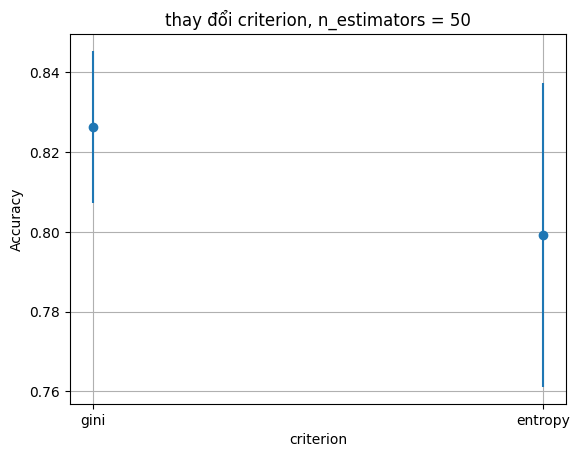

In [61]:
title = "thay đổi criterion, n_estimators = 50"
xlabel = "criterion"
X = []
Y = []
error = []

for criterion in tqdm(["gini", "entropy"]):
    # Với mỗi criterion nhận được,
    # thực hiện xây dựng mô hình, huấn luyện và đánh giá theo cross-validation
    text_clf = RandomForestClassifier(criterion=criterion, n_estimators=50)
    mean, std = cross_validation(text_clf)
    X.append(str(criterion))
    Y.append(mean)
    error.append(std)

# lưu kết quả ra file ảnh
plot(title, xlabel, X, Y, error)
plt.savefig('images/RF_change_criterion.png', bbox_inches='tight')
plt.show()


### Số cây trong mô hình Random Forest 

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:44<00:00, 11.17s/it]


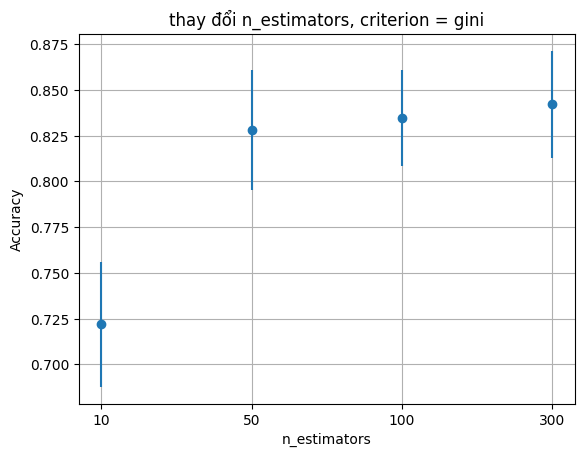

In [92]:
title = "thay đổi n_estimators, criterion = gini"
xlabel = "n_estimators"
X = []
Y = []
error = []

for n_estimators in tqdm([10, 50, 100, 300]):
    # Với từng giá trị n_estimators nhận được,
    # thực hiện xây dựng mô hình, huấn luyện và đánh giá theo cross-validation
    text_clf = RandomForestClassifier(criterion='gini', n_estimators=n_estimators)
    mean, std = cross_validation(text_clf)
    X.append(str(n_estimators))
    Y.append(mean)
    error.append(std)

# lưu kết quả ra file ảnh
plot(title, xlabel, X, Y, error)
plt.savefig('images/RF_change_N.png', bbox_inches='tight')
plt.show()


### Tham số __K__ trong mô hình KNN

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.76it/s]


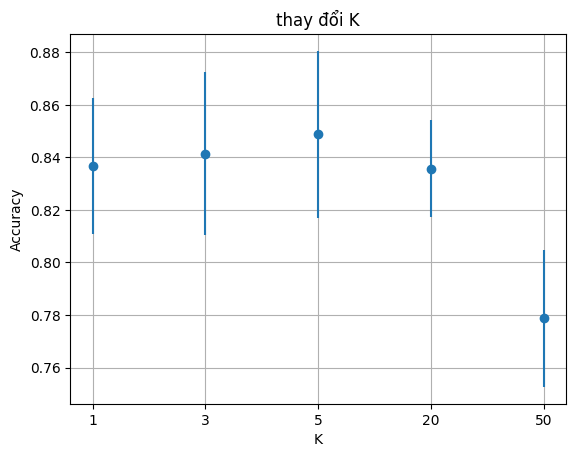

In [63]:
title = "thay đổi K"
xlabel = "K"
X = []
Y = []
error = []

for k in tqdm([1, 3, 5, 20, 50]):
    # Với từng giá trị k nhận được,
    # thực hiện xây dựng mô hình, huấn luyện và đánh giá theo cross-validation
    text_clf = KNeighborsClassifier(n_neighbors=k)
    mean, std = cross_validation(text_clf)
    X.append(str(k))
    Y.append(mean)
    error.append(std)

# lưu kết quả ra file ảnh
plot(title, xlabel, X, Y, error)
plt.savefig('images/KNN_change_K.png', bbox_inches='tight')
plt.show()


## 4. So sánh các mô hình với các bộ tham số tốt nhất  

In [64]:
svm_ = svm.SVC(kernel='linear', C=1.0)
rf = RandomForestClassifier(criterion='gini', n_estimators=100)
knn = KNeighborsClassifier(n_neighbors=5)

# Huấn luyện các mô hình trên tập dữ liệu train đầy đủ
svm_.fit(X_train, Y_train)
rf.fit(X_train, Y_train)
knn.fit(X_train, Y_train)

KNeighborsClassifier()

In [65]:
# Kết quả dự đoán trên tập test
print(f'SVM: {accuracy_score(Y_test, svm_.predict(X_test))}')
print(f'RF: {accuracy_score(Y_test, rf.predict(X_test))}')
print(f'KNN: {accuracy_score(Y_test, knn.predict(X_test))}')

SVM: 0.9253731343283582
RF: 0.8283582089552238
KNN: 0.8395522388059702


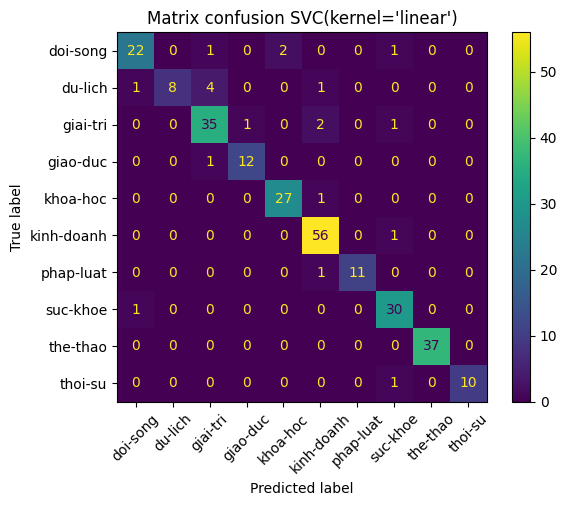

In [93]:
def plot_confusion_matrix(estimator, X, Y):
    y_pred = estimator.predict(X)
    cm = confusion_matrix(Y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=data_train.target_names)
    disp.plot()
    plt.xticks(rotation=45)
    plt.title(f'Matrix confusion {estimator}')
    plt.savefig(f'images/confusion_matrix_{estimator}.png', bbox_inches='tight')
    plt.show()
plot_confusion_matrix(svm_, X_test, Y_test)

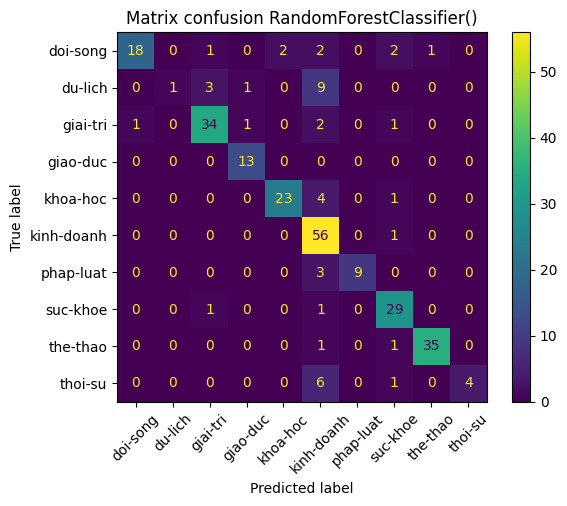

In [94]:
plot_confusion_matrix(rf, X_test, Y_test)

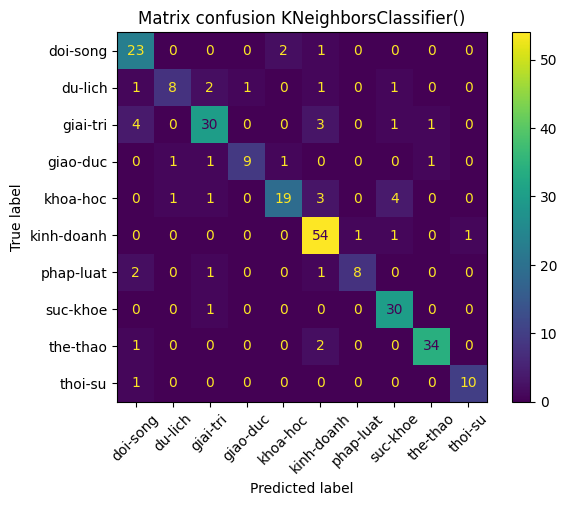

In [95]:
plot_confusion_matrix(knn, X_test, Y_test)